In [1]:
import os
import sys
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models

from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 加载数据
可视化数据

In [2]:
train, test = mnist.load_data()
train_x, train_y, test_x, test_y = train[0], train[1], test[0], test[1]

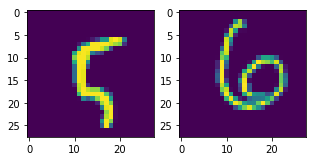

In [3]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(train_x[100])
plt.subplot(1,2,2)
plt.imshow(test_x[100])
plt.show()

# 编写dataloader
数据生成器，用于训练

In [4]:
class DataGen(Dataset):
    def __init__(self, data, label, transforms=None):
        self.data = data
        self.label = label
        self.transforms = transforms
        
    def __getitem__(self, index):
        img = self.data[index]
        img = np.expand_dims(img, -1)
        tag = self.label[index]
        if self.transforms:
            img = self.transforms(img)
        return img, tag

    def __len__(self):
        return self.data.shape[0]

In [5]:
traingen = DataGen(train_x, train_y, transforms=transforms.Compose([transforms.ToTensor()]))
trainloader = DataLoader(dataset=traingen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)
testgen = DataGen(test_x, test_y, transforms=transforms.Compose([transforms.ToTensor()]))
testloader = DataLoader(dataset=testgen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)

# 创建模型

In [6]:
class SimpleModel(torch.nn.Module):
    def __init__(self, categroies):
        super(SimpleModel, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1, bias=False),
                                          torch.nn.BatchNorm2d(num_features=8),
                                          torch.nn.ReLU(),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
                                          torch.nn.BatchNorm2d(num_features=16),
                                          torch.nn.ReLU(),
                                          torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(in_features=7*7*16, out_features=categroies)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x
    



In [7]:
model = SimpleModel(10)
# 交叉熵内部做softmax，所以模型的最后一层不需要加softmax激活函数
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# 开始训练

In [8]:
epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
for i in range(epochs):
    for j, (img, tag) in enumerate(trainloader):
        img = img.to(device)
        tag = tag.to(device)
        # print(tag)
        output = model(img)
        loss = criterion(output, tag.type(torch.cuda.LongTensor))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if j % 100 == 0:
            print('{}/{}, steps:{}, loss:{}'.format(i+1, epochs, j+1, loss.item()))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for img, tag in testloader:
            img = img.to(device)
            tag = tag.to(device).type(torch.cuda.LongTensor)
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == tag).sum().item()
            total += tag.shape[0]
        print('Average Accuracy is {}'.format(correct / total))  

1/10, steps:1, loss:2.3714566230773926
1/10, steps:101, loss:0.5173688530921936
1/10, steps:201, loss:0.2653545141220093
1/10, steps:301, loss:0.15274108946323395
1/10, steps:401, loss:0.22296205163002014
1/10, steps:501, loss:0.1274479329586029
1/10, steps:601, loss:0.04120491072535515
1/10, steps:701, loss:0.1828516572713852
1/10, steps:801, loss:0.06340346485376358
1/10, steps:901, loss:0.0825238972902298
1/10, steps:1001, loss:0.02459488995373249
1/10, steps:1101, loss:0.11977686733007431
1/10, steps:1201, loss:0.04187004640698433
1/10, steps:1301, loss:0.038930751383304596
1/10, steps:1401, loss:0.3668687343597412
1/10, steps:1501, loss:0.02016628347337246
1/10, steps:1601, loss:0.013538673520088196
1/10, steps:1701, loss:0.005016855895519257
1/10, steps:1801, loss:0.1457785665988922
Average Accuracy is 0.9800681089743589
2/10, steps:1, loss:0.1934467852115631
2/10, steps:101, loss:0.17865468561649323
2/10, steps:201, loss:0.13472557067871094
2/10, steps:301, loss:0.08578787744045

10/10, steps:1101, loss:0.004707172513008118
10/10, steps:1201, loss:0.0017499513924121857
10/10, steps:1301, loss:0.011861233040690422
10/10, steps:1401, loss:0.04933084547519684
10/10, steps:1501, loss:0.007391378283500671
10/10, steps:1601, loss:0.010394856333732605
10/10, steps:1701, loss:0.007220812141895294
10/10, steps:1801, loss:0.053185343742370605
Average Accuracy is 0.987479967948718


# 保存模型

In [9]:
torch.save(model.state_dict(), 'mnist.ckpt')

# 加载权重测试
查看测试结果与训练过程中的测试结果是否保持一致

In [10]:
model = SimpleModel(10)
model.load_state_dict(torch.load('mnist.ckpt'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for img, tag in testloader:
        img = img.to(device)
        tag = tag.to(device).type(torch.cuda.LongTensor)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == tag).sum().item()
        total += tag.shape[0]
    print('Average Accuracy is {}'.format(correct / total)) 

Average Accuracy is 0.9875801282051282
